# LKJ Cholesky Covariance Priors for Multivariate Normal Models

> While the inverse-Wishart distribution is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is not very well-suited to modern Bayesian computational methods.
> For this reason, the LKJ prior is recommended when modeling the covariance matrix of a multivariate normal distribution.

We will demonstrate modeling the covariance with the LKJ distribution using mock data.

In [1]:
import warnings

import arviz as az
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from icecream import ic
from matplotlib import pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(3264602)
gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = "retina"

In [2]:
N = 10000

μ_actual = np.array([1.0, -2.0])
σ_actual = np.array([0.7, 1.5])
Ρ_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(σ_actual) * Ρ_actual * np.diag(σ_actual)

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

ic(Σ_actual);

ic| Σ_actual: matrix([[ 0.49, -0.42],
                      [-0.42,  2.25]])


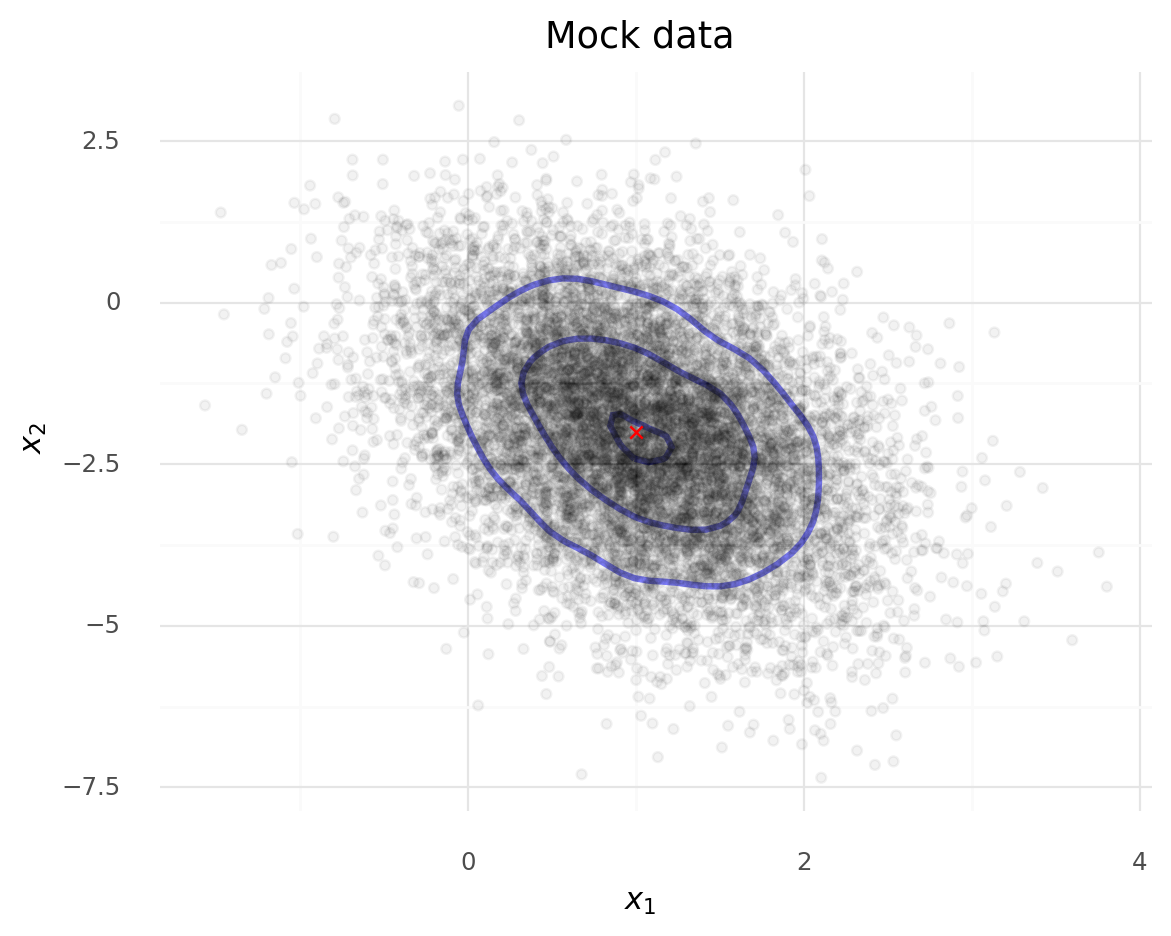

<ggplot: (362124301)>

In [15]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

plot_data = pd.DataFrame(x, columns=("x1", "x2"))

(
    gg.ggplot(plot_data, gg.aes(x="x1", y="x2"))
    + gg.geom_density_2d(alpha=0.5, size=1.3, color="blue")
    + gg.geom_point(alpha=0.05)
    + gg.geom_point(
        data=pd.DataFrame(μ_actual.reshape((1, 2)), columns=("x1", "x2")),
        color="red",
        shape="x",
        size=2,
    )
    + gg.labs(x="$x_1$", y="$x_2$", title="Mock data")
)

The sampling distribution for the multivariate normal model is $\textbf{x} \sim N(\mu, \Sigma)$ where $\Sigma$ is the covariance matrix: $\Sigma = \text{Cov}(x_i, x_j)$.

The LKJ distribution puts a prior on the correlation matrix, $\textbf{C} = \text{Corr}(x_i, x_j)$.
When combined with priors on the standard deviations on each component, this induces a prior on the covariance matrix $\Sigma$.

Inverting $\Sigma$ is unstable and slow, so we can use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition), $\Sigma = \textbf{LL}^T$, where $\textbf{L}$ is a lower-triangular matrix.

PyMC3 supports the LKJ priors for the Cholesky decomposition of the covariance matrix via the `LKJCholeskyCov()` distribution.
It has two parameters: 1) `n` is the dimensions of the observations $\textbf{x}$ and 2) the PyMC2 distribution of the component standard deviations.
It also has a hyperparameter `eta` which controls the amount of correlation between components of $\textbf{x}$.
A value of `eta=1` creates a uniform distribution on correlations matrix, and the magnitude of correlations decreases as `eta` increases.

Usually, we are interested in the posteriors of the correlations matrix and the standard deviations, not the Cholesky covariance matrix (they are more interpretable and have scientific meaning in the model).
We can have PyMC3 automatically compute these posteriors and store them in the trace by setting `compute_corr=True`.

In [24]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

    trace = pm.sample(init="adapt_diag", random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.


In [25]:
az_model = az.from_pymc3(trace=trace, model=model)
az.summary(az_model, hdi_prob=0.89)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],1.017,0.007,1.007,1.028,0.000,0.0,2496.0,2494.0,2510.0,1760.0,1.0
μ[1],-2.032,0.015,-2.060,-2.011,0.000,0.0,2700.0,2695.0,2696.0,1746.0,1.0
chol[0],0.694,0.005,0.686,0.701,0.000,0.0,2625.0,2625.0,2631.0,1533.0,1.0
chol[1],-0.589,0.015,-0.612,-0.565,0.000,0.0,2646.0,2646.0,2636.0,1568.0,1.0
chol[2],1.378,0.009,1.363,1.393,0.000,0.0,3356.0,3356.0,3343.0,1407.0,1.0
chol_stds[0],0.694,0.005,0.686,0.701,0.000,0.0,2625.0,2625.0,2631.0,1533.0,1.0
chol_stds[1],1.499,0.011,1.483,1.517,0.000,0.0,3336.0,3336.0,3328.0,1666.0,1.0
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.0,2000.0,2000.0,2000.0,2000.0,NaN
"chol_corr[0,1]",-0.393,0.009,-0.407,-0.380,0.000,0.0,2641.0,2641.0,2648.0,1518.0,1.0
"chol_corr[1,0]",-0.393,0.009,-0.407,-0.380,0.000,0.0,2641.0,2641.0,2648.0,1518.0,1.0


/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:1037: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/density_utils.py:1037: Ru

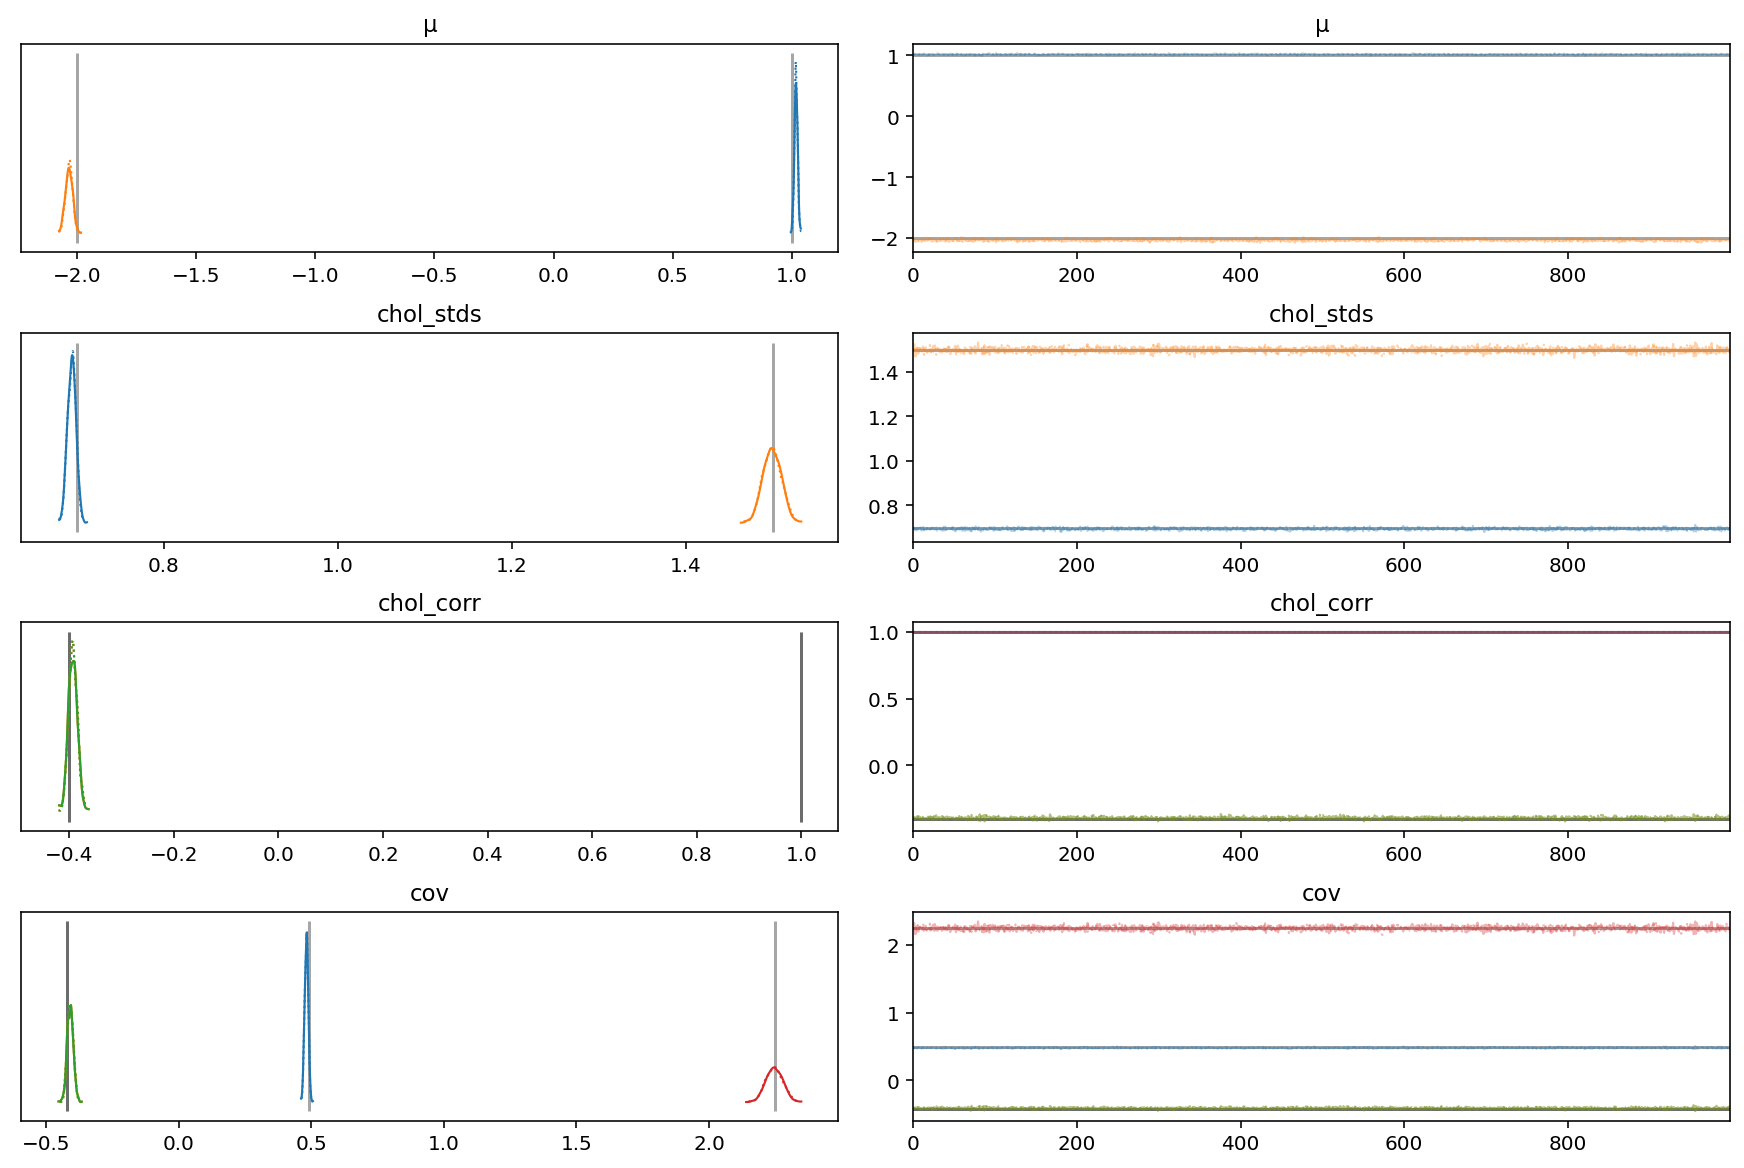

In [26]:
az.plot_trace(
    az_model,
    var_names=["~chol"],
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, σ_actual),
        ("chol_corr", {}, Ρ_actual),
    ],
);

Get the posterior predictions and compare to the actual values.

In [30]:
μ_post = trace["μ"].mean(axis=0)
μ_post

array([ 1.01671391, -2.03193021])

In [32]:
# Error in μ
(1 - μ_post / μ_actual).round(2)

array([-0.02, -0.02])

In [33]:
Σ_post = trace["cov"].mean(axis=0)
Σ_post

array([[ 0.48176829, -0.40905125],
       [-0.40905125,  2.24689291]])

In [35]:
# Error in Σ
(1 - Σ_post / Σ_actual).round(2)

array([[0.02, 0.03],
       [0.03, 0.  ]])

---

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Feb 14 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

pandas    : 1.2.2
plotnine  : 0.7.1
arviz     : 0.11.1
pymc3     : 3.11.1
seaborn   : 0.11.1
numpy     : 1.20.1
matplotlib: 3.3.4

Watermark: 2.1.0

